<a href="https://colab.research.google.com/github/ethanzell/ethanzell/blob/main/Large_Particle_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import copy
import math
from scipy.spatial import distance
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from copy import copy
import matplotlib.pyplot as plt

In [2]:
def get_transition_list(d):
  """
  Generates a list of possible transitions from a state for a grid with dimensions d x d.
  
  Parameters:
  d (int): The number of rows and columns in the grid. The grid is assumed to be of size d x d.
  
  Returns:
  directions (list): A list of lists containing the possible transitions from each state. Each sublist contains
                      two integers representing the row and column coordinates of a neighboring state. 
  """
  directions = []
  for k in range(d):
      for l in range(d):
          from_k = [k]
          if k != l:
              from_k.append(l)
          if len(from_k)>1:
              directions.append(from_k)    
  return directions

In [3]:
get_transition_list(3)

[[0, 1], [0, 2], [1, 0], [1, 2], [2, 0], [2, 1]]

In [4]:
def d_state_transition(index_moves, process_position, tuple_moves_list, d):
    """
    Simulates a transition between two states.

    Args:
    - index_moves (int): the index of the transition to be performed, i.e., the index of the tuple
      in `tuple_moves_list` that represents the transition.
    - process_position (list): a list representing the current state of the process, with the i-th
      element indicating the number of particles in the i-th state.
    - tuple_moves_list (list): a list of tuples, each representing a possible transition of the process.
      The first element of the tuple is the index of the state from which the transition starts, and the
      second element is the index of the state to which the transition goes.
    - d (int): the number of possible states of any particle in the process.

    Returns:
    - list: a list representing the new state of the process after the transition, with the i-th
      element indicating the number of particles in the i-th state.
    """
    process_position[tuple_moves_list[index_moves][0]] -= 1
    process_position[tuple_moves_list[index_moves][1]] += 1

    return process_position

In [5]:
'''
The following are various particle rate functions to play around with in the simulation. 
'''

def lipschitz_rate(proportion):
  # single agent rate given agent's current location and the proportion of players in their state
  return 5*proportion

def abs_val(proportion):
  return abs(proportion - 0.5)*5

def discts_rate(proportion):
  if proportion > 0.9:
    return 10
  elif proportion > 0.8:
    return 5
  else:
    return 10

def highly_discts_rate(proportion):
  if int(proportion*100) % 2 == 0:
    return 10
  return 5

def medium_discts_rate(proportion):
  if int(proportion*10) % 2 ==0:
    return 10
  return 5

def pressure_control_center(proportion):
  return (abs(proportion - 0.5) + 1.)*5.

def pressure_control_edge(proportion): # should cause aggregation to the edge 
  return (abs(1.-proportion)+0.1)*6.


# this control is written differently than the others
def inflow_outflow_control(current_process_proportion, target_proportion):
  # each value is the proportion in a fixed state
  if current_process_proportion <= target_proportion:
    return 5
  else:
    return 10

def max_control(proportion):
  return 10

def min_control(proportion):
  return 5

In [8]:
def distribution_hitting_time(process_start, n, ball_diameter = 0.01, d=2, rate_selector=lipschitz_rate, verbose=False):
  """
  Calculates the hitting time distribution of a process starting at `process_start` until it reaches the boundary of a 
  ball with radius `ball_diameter*n` around the initial state. Every particle in the process has `d` states, and the 
  transition rates between the states are calculated using the `rate_selector` function. The parameter `verbose` 
  controls whether to print information about the process at each step.

  Parameters:
  -----------
  process_start: tuple[int]
      A tuple representing the initial state of the Markov chain, where the `i`-th element is the number of agents 
      in state `i`.
  n: int
      The total number of agents in the system.
  ball_diameter: float, optional (default=0.01)
      The diameter of the ball around the initial state that represents the boundary to be reached by the Markov chain.
  d: int, optional (default=2)
      The number of states in the Markov chain.
  rate_selector: Callable[[float], float], optional (default=lipschitz_rate)
      A function that takes in a float between 0 and 1 and returns a float representing the transition rate between 
      two states for a single agent. The default function `lipschitz_rate` is a simple Lipschitz function with a 
      threshold parameter of 0.5.
  verbose: bool, optional (default=False)
      Whether to print information about the process at each step.

  Returns:
  --------
  total_time: float
      The total time taken for the Markov chain to reach the boundary of the ball around the initial state, measured 
      in the same units as the transition rates calculated by `rate_selector`.
  """

  total_time = 0
  process_position = process_start
  if verbose:
    print(f'Process start: {process_start}')
  
  tuple_moves_list = get_transition_list(d)

  terminal_state_low = process_start[0]-math.floor(n*ball_diameter)
  terminal_state_high = process_start[0]+math.floor(n*ball_diameter)
  
  while (process_position[0] >= terminal_state_low) and (process_position[0] <= terminal_state_high):

    if verbose:
      print(process_position)

    # calculate current transition rates
    
    transition_rates = []
    for k in range(len(tuple_moves_list)):
      single_agent_rate = rate_selector(process_position[tuple_moves_list[k][0]]/float(n)) # ONLY WORKS FOR d=2
      transition_rates.append(process_position[tuple_moves_list[k][0]]*single_agent_rate)

    jump_times = []

    for i in range(len(transition_rates)):
      if transition_rates[i]==0:
        # -1 is a flag to omit this possibility
        jump_times.append(-1)
      else:
        jump_times.append(np.random.exponential(1.0/transition_rates[i]))
    
    index_moves = 0
    # just put some high number, shouldn't matter
    minimal_time = 1000
    for i in range(len(jump_times)):
      if jump_times[i] > 0 and jump_times[i]<minimal_time:
        index_moves = i
        minimal_time = jump_times[i]
    
    total_time += minimal_time

    # this just describes how to move, see the above cell
    process_position = d_state_transition(index_moves,process_position,tuple_moves_list,d)    

  return total_time

In [9]:
def graph_hitting_times(hit_time_list, bins):
    """
    Generates a plot of hitting times from a list of hitting times.

    Parameters:
    -----------
    hit_time_list: List[float]
        A list of hitting times from a simulation.
    bins: int
        The number of bins to use in the plot.

    Returns:
    --------
    None
        The plot.

    Example:
    --------
    >>> hit_times = [3.2, 4.8, 5.6, 6.1, 7.3, 8.4, 9.0]
    >>> graph_hitting_times(hit_times, 10)
    """
    sorted_times = sorted(hit_time_list)
    samples = len(sorted_times)

    time_bins = np.linspace(0, sorted_times[-1], bins)
    y = [0 for _ in range(len(time_bins))]

    bin_index = 0
    time_index = 0
    while time_index < samples - 1:
        time = sorted_times[time_index]
        if time >= time_bins[bin_index]:
            y[bin_index] = float(samples - time_index) / samples
            bin_index += 1
        else:
            time_index += 1

    plt.plot(time_bins, y, alpha=0.75)
    return 


In [10]:
def LOG(x):
  if x == 0:
    return 0
  else:
    return math.log(x)


def graph_LOG_hitting_times(hit_time_list, bins):
  sorted_times = sorted(hit_time_list)
  samples = len(sorted_times)

  time_bins = np.linspace(0,sorted_times[-1], bins)
  y = [0 for _ in range(len(time_bins))]

  bin_index = 0
  time_index = 0
  while time_index < samples - 1:
    time = sorted_times[time_index]
    if time >= time_bins[bin_index]:
      y[bin_index] = float(samples - time_index)/samples
      bin_index += 1
    else:
      time_index += 1
  
  plt.plot(time_bins, np.array(list(map(LOG, y))), alpha=0.75)
  return

In [11]:
def overlay_hitting_time_graphs(hit_time_array, num_players_list, starting_string,samples, bins):

  colors = ['r','g','b','c','m','y']

  sorted_array = np.sort(hit_time_array, axis=0)
  time_bins = np.linspace(0,np.max(sorted_array), bins)
  y_array = np.zeros((bins, sorted_array.shape[1]))

  for j,num in enumerate(num_players_list):
    bin_index = 0
    time_index = 0
    while time_index < samples - 1:
      time = sorted_array[time_index][j]
      if time >= time_bins[bin_index]:
        y_array[bin_index][j] = float(samples - time_index)/samples
        bin_index += 1
      else:
        time_index += 1
    plt.plot(time_bins, y_array[:,j], alpha=0.75, label=f'n={num}', color=colors[j])
  plt.xlabel("t")
  plt.ylabel("P(T>t)")
  plt.title(f"Started at "+starting_string)
  plt.legend()
  plt.show()
  return

In [12]:
def overlay_LOG_hitting_time_graphs(hit_time_array, num_players_list, starting_string,samples, bins):

  colors = ['r','g','b','c','m','y']

  sorted_array = np.sort(hit_time_array, axis=0)
  time_bins = np.linspace(0,np.max(sorted_array), bins)
  y_array = np.zeros((bins, sorted_array.shape[1]))

  for j,num in enumerate(num_players_list):
    bin_index = 0
    time_index = 0
    while time_index < samples - 1:
      time = sorted_array[time_index][j]
      if time >= time_bins[bin_index]:
        y_array[bin_index][j] = float(samples - time_index)/samples
        bin_index += 1
      else:
        time_index += 1
    plt.plot(time_bins, np.array(list(map(LOG, y_array[:,j]))), alpha=0.75, label=f'n={num}', color=colors[j])
  plt.xlabel("t")
  plt.ylabel("log(P(T>t))")
  plt.title(f"Started at "+starting_string)
  plt.legend()
  plt.show()
  return

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

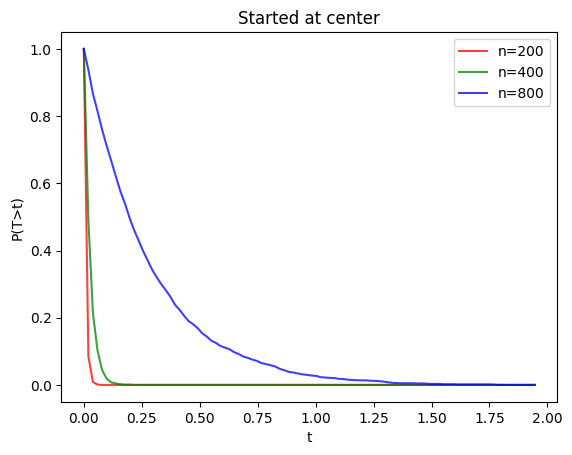

In [13]:
# EXAMPLE IMPLEMENTATION
num_players_list = [200, 400, 800]
samples = 2_000
rate = highly_discts_rate
start_list = [[100,100],[200,200],[400,400]]

final_time_hit = np.zeros((samples,len(num_players_list)))

for j in range(len(num_players_list)):
  for i in tqdm(range(samples)):
    final_time_hit[i][j] = distribution_hitting_time(process_start = copy(start_list[j]), n = num_players_list[j], d = 2, rate_selector=rate, verbose=False)

overlay_hitting_time_graphs(hit_time_array=final_time_hit, num_players_list=num_players_list, 
                            starting_string='center',samples=samples, bins=100)